# NORTHWIND DATABASE

El **objetivo** de este ejercicio es generar una serie de consultas SQL que permitan extraer información relevante de la base de datos y luego exportar los resultados para construir dashboards o visualizaciones que proporcionen insights valiosos para la toma de decisiones empresariales.

La base de datos Northwind es una base de datos de ejemplo clásica que simula las operaciones de una empresa minorista. Contiene tablas relacionales que representan diferentes aspectos del negocio, como productos, clientes, pedidos y empleados. Utilizando consultas SQL, podrás explorar y analizar estos datos para comprender mejor el desempeño del negocio en diferentes áreas.

Una vez que hayas realizado las consultas SQL y obtenido los resultados, podrás utilizarlos para herramientas de visualización de datos como Tableau, Power BI, Streamlit o cualquier otra herramienta de tu elección. 

![img](./img/northwind-er-diagram.png)

Tendrás que elegir uno de los retos a resolver: 

In [242]:
import pandas as pd
import sqlite3 
import os 
import matplotlib.pyplot as plt
import seaborn as sns 
from geopy.geocoders import Nominatim 
import folium
from IPython.display import IFrame
from folium import plugins 
os.getcwd() 

'c:\\Users\\rodri\\OneDrive\\Escritorio\\DATA_SCIENCE\\CODIGO_CLASES\\TheBridge_DSPT-1\\2-Data_Analysis\\6-Bases_de_datos\\Práctica'

In [243]:
# Conectamos con la base de datos chinook.db
connection = sqlite3.connect("northwind.db")

# Obtenemos un cursor que utilizaremos para hacer las queries
crsr = connection.cursor() 

In [244]:
# Con esta función leemos los datos y lo pasamos a un DataFrame de Pandas
def sql_query(query):

    # Ejecuta la query
    crsr.execute(query)

    # Almacena los datos de la query 
    ans = crsr.fetchall()

    # Obtenemos los nombres de las columnas de la tabla
    names = [description[0] for description in crsr.description]

    return pd.DataFrame(ans,columns=names) 

In [245]:
# Conectar a la base de datos
connection = sqlite3.connect('C:/Users/rodri/OneDrive/Escritorio/DATA_SCIENCE/CODIGO_CLASES/TheBridge_DSPT-1/2-Data_Analysis/6-Bases_de_datos/Práctica/data/northwind.db')

# Obtener un cursor
crsr = connection.cursor()

# Consultar los nombres de las tablas en la base de datos
crsr.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = crsr.fetchall()

# Imprimir los nombres de las tablas
print("Tablas en la base de datos:")
for table in tables:
    print(table[0]) 

Tablas en la base de datos:
Categories
sqlite_sequence
CustomerCustomerDemo
CustomerDemographics
Customers
Employees
EmployeeTerritories
Order Details
Orders
Products
Regions
Shippers
Suppliers
Territories


### **1. Análisis de Ventas por Región**
Analiza las ventas de productos por región. El objetivo es identificar las regiones que generan más ingresos y las tendencias de ventas a lo largo del tiempo en esas regiones. 
Pista: Utiliza gráficos de barras y líneas para mostrar la evolución de las ventas, así como mapas geográficos para visualizar la distribución de ingresos por región. 

In [210]:
# Consultas SQL para análisis
sales_by_region_query = """
SELECT 
    c.Region,
    SUM(od.Quantity * od.UnitPrice) AS TotalSales
FROM 
    Orders o
JOIN 
    Customers c ON o.CustomerID = c.CustomerID
JOIN 
    'Order Details' od ON o.OrderID = od.OrderID
GROUP BY 
    c.Region
ORDER BY 
    TotalSales DESC;
"""

sales_trends_query = """
SELECT 
    c.Region,
    strftime('%Y-%m', o.OrderDate) AS OrderMonth,
    SUM(od.Quantity * od.UnitPrice) AS MonthlySales
FROM 
    Orders o
JOIN 
    Customers c ON o.CustomerID = c.CustomerID
JOIN 
    'Order Details' od ON o.OrderID = od.OrderID
GROUP BY 
    c.Region, OrderMonth
ORDER BY 
    OrderMonth, c.Region;
"""

# Ejecutar consultas y cargar los datos en DataFrames
sales_by_region_df = pd.read_sql_query(sales_by_region_query, connection)
sales_trends_df = pd.read_sql_query(sales_trends_query, connection)

# Cerrar la conexión a la base de datos
connection.close()

# Visualizar datos cargados
print("Sales by Region:\n", sales_by_region_df.head())
print("\nSales Trends by Region:\n", sales_trends_df.head()) 

Sales by Region:
             Region    TotalSales
0   Western Europe  1.337090e+08
1    South America  7.947230e+07
2    North America  7.682635e+07
3  Southern Europe  4.756303e+07
4    British Isles  3.870052e+07

Sales Trends by Region:
             Region OrderMonth  MonthlySales
0             None    2012-07      75921.82
1    British Isles    2012-07     107411.81
2  Central America    2012-07     117527.23
3   Eastern Europe    2012-07      31950.80
4    North America    2012-07     244663.69


In [211]:
# Filtrar los valores None en el campo 'Region'
sales_by_region_df = sales_by_region_df[sales_by_region_df['Region'].notna()] 

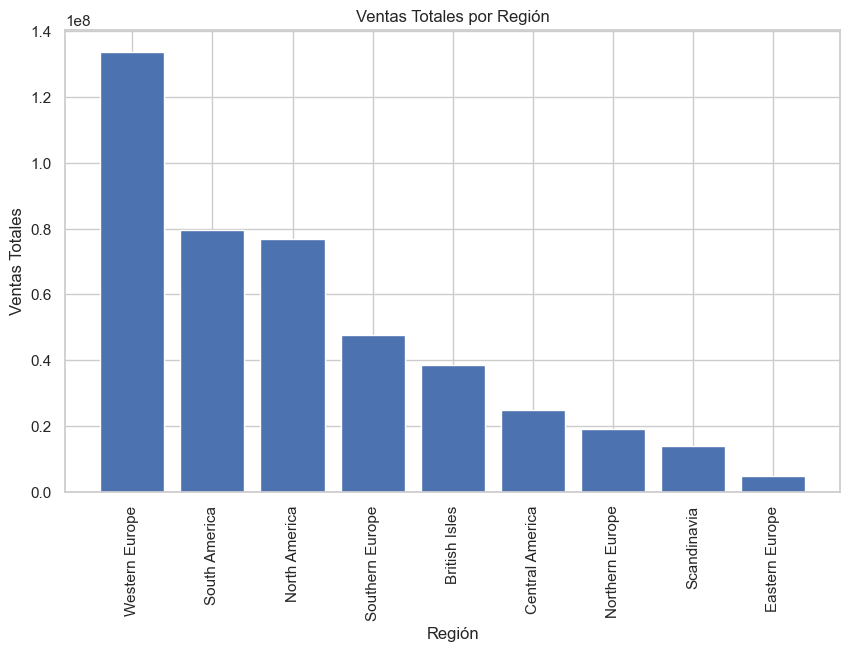

In [212]:
# Gráfico de barras de las ventas por región
plt.figure(figsize=(10, 6))
plt.bar(sales_by_region_df['Region'], sales_by_region_df['TotalSales'])
plt.xlabel('Región')
plt.ylabel('Ventas Totales')
plt.title('Ventas Totales por Región')
plt.xticks(rotation=90)
plt.show() 

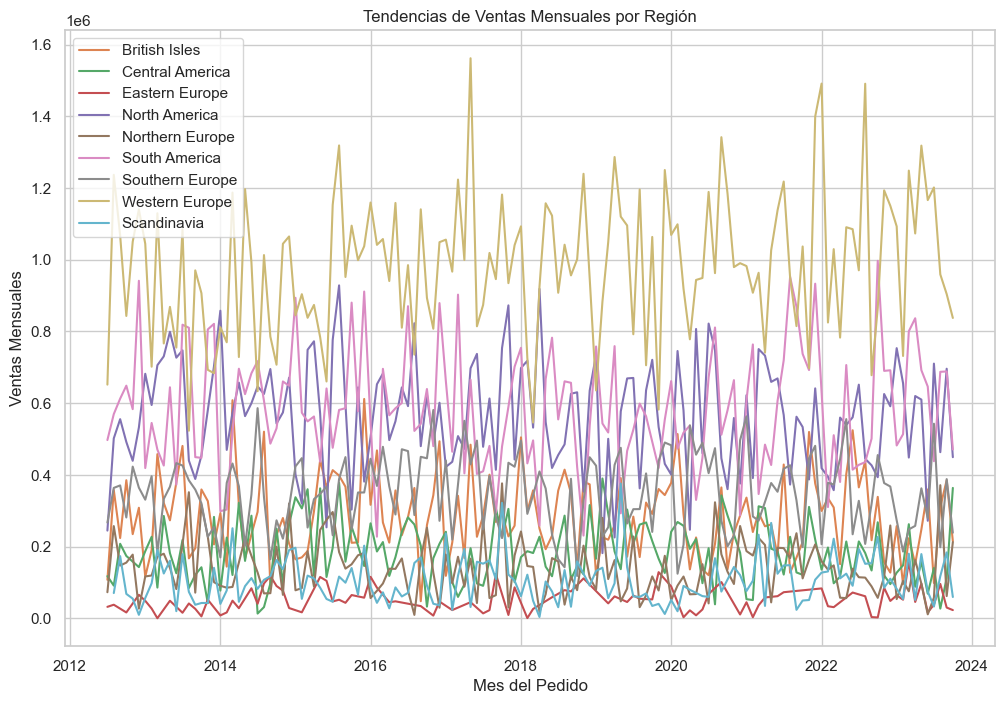

In [213]:
# Convertir OrderMonth a tipo datetime para facilitar el plot
sales_trends_df['OrderMonth'] = pd.to_datetime(sales_trends_df['OrderMonth'])

# Gráfico de líneas de tendencias de ventas por región
plt.figure(figsize=(12, 8))
for region in sales_trends_df['Region'].unique():
    region_data = sales_trends_df[sales_trends_df['Region'] == region]
    plt.plot(region_data['OrderMonth'], region_data['MonthlySales'], label=region)

plt.xlabel('Mes del Pedido')
plt.ylabel('Ventas Mensuales')
plt.title('Tendencias de Ventas Mensuales por Región')
plt.legend()
plt.show() 

In [239]:
import sqlite3
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from IPython.display import IFrame
from folium import plugins

# Conectar a la base de datos SQLite
db_path = 'C:/Users/rodri/OneDrive/Escritorio/DATA_SCIENCE/CODIGO_CLASES/TheBridge_DSPT-1/2-Data_Analysis/6-Bases_de_datos/Práctica/data/northwind.db'
conn = sqlite3.connect(db_path)

# Consulta SQL para obtener ventas por ciudad
sales_by_city_query = """
SELECT 
    o.ShipCity AS City,
    SUM(od.Quantity * od.UnitPrice * (1 - od.Discount)) AS TotalSales
FROM 
    Orders o
JOIN 
    'Order Details' od ON o.OrderID = od.OrderID
GROUP BY 
    o.ShipCity
ORDER BY 
    TotalSales DESC;
"""

# Ejecutar consulta y cargar los datos en un DataFrame
sales_by_city_df = pd.read_sql_query(sales_by_city_query, conn)

# Cerrar la conexión a la base de datos
conn.close()

# Inicializar el geocodificador
geolocator = Nominatim(user_agent="northwind_analysis")

# Función para obtener coordenadas geográficas
def get_coordinates(city):
    try:
        location = geolocator.geocode(city)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except:
        return None, None

# Obtener coordenadas para cada ciudad
sales_by_city_df['Lat'], sales_by_city_df['Lng'] = zip(*sales_by_city_df['City'].apply(get_coordinates))

# Filtrar filas con coordenadas no disponibles
sales_by_city_df = sales_by_city_df.dropna(subset=['Lat', 'Lng'])

# Crear un mapa centrado en el centro geográfico de las ciudades
m = folium.Map(location=[20, 0], zoom_start=2)

# Crear una escala de colores
colormap = folium.LinearColormap(
    colors=['green', 'yellow', 'red'],
    vmin=sales_by_city_df['TotalSales'].min(),
    vmax=sales_by_city_df['TotalSales'].max(),
    caption='Total Sales'
)

# Añadir los datos de ventas por ciudad al mapa con la escala de colores
for idx, row in sales_by_city_df.iterrows():
    folium.CircleMarker(
        location=[row['Lat'], row['Lng']],
        radius=row['TotalSales'] / 100000,  # Ajustar el factor de escala según sea necesario
        popup=f"{row['City']}: ${row['TotalSales']:,.2f}",
        color=colormap(row['TotalSales']),
        fill=True,
        fill_color=colormap(row['TotalSales'])
    ).add_to(m)

# Añadir la escala de colores al mapa
colormap.add_to(m)

# Guardar el mapa como un archivo HTML
m.save('C:/Users/rodri/OneDrive/Escritorio/DATA_SCIENCE/CODIGO_CLASES/TheBridge_DSPT-1/2-Data_Analysis/6-Bases_de_datos/Práctica/data/sales_by_city_map.html')

# Mostrar el mapa en Jupyter Notebook (si estás usando Jupyter Notebook) 
IFrame(src='sales_by_city_map.html', width=700, height=500) 

### **2. Análisis de Desempeño de Productos**
Analiza el desempeño de los productos de la empresa. Examina las ventas de productos por categoría, identificando los productos más vendidos y los menos vendidos. 

Pista: Utiliza gráficos de barras y de tarta para visualizar la participación de mercado de cada categoría y los ingresos generados por los productos individuales.

In [246]:
# Definir la consulta SQL
query = """
SELECT 
    c.CategoryName AS Category,
    p.ProductName AS Product,
    SUM(od.Quantity * od.UnitPrice) AS TotalSales
FROM 
    [Order Details] od
JOIN 
    Products p ON od.ProductID = p.ProductID
JOIN 
    Categories c ON p.CategoryID = c.CategoryID
GROUP BY 
    c.CategoryName, p.ProductName
ORDER BY 
    TotalSales DESC;
"""

In [247]:
# Ejecutar la consulta y cargar los datos en un DataFrame de Pandas
sales_data = pd.read_sql_query(query, connection)  

In [248]:
# Cerrar la conexión a la base de datos
#connection.close()

# Ver los primeros registros del DataFrame
print(sales_data.head()) 

       Category                  Product   TotalSales
0     Beverages            Côte de Blaye  53274482.70
1  Meat/Poultry  Thüringer Rostbratwurst  24630836.96
2  Meat/Poultry          Mishi Kobe Niku  19424638.00
3   Confections   Sir Rodney's Marmalade  16654879.80
4       Seafood         Carnarvon Tigers  12607487.50


In [249]:
# Configurar estilos de Seaborn
sns.set_theme(style="whitegrid") 

C:\Users\rodri\AppData\Local\Temp\ipykernel_10844\3536168105.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Category', y='TotalSales', data=sales_data, estimator=sum, ci=None)


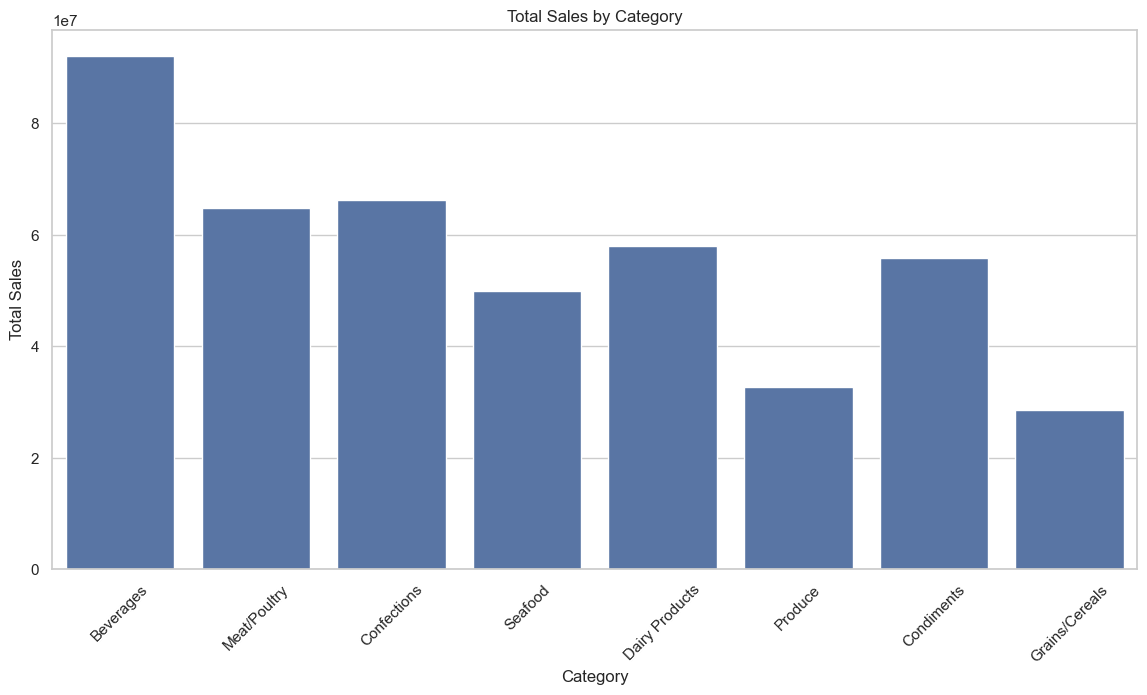

In [162]:
# Crear un gráfico de barras para mostrar las ventas por categoría
plt.figure(figsize=(14, 7))
sns.barplot(x='Category', y='TotalSales', data=sales_data, estimator=sum, ci=None)
plt.title('Total Sales by Category')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show() 

C:\Users\rodri\AppData\Local\Temp\ipykernel_10844\1819941113.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Product', y='TotalSales', data=top_products, ci=None)


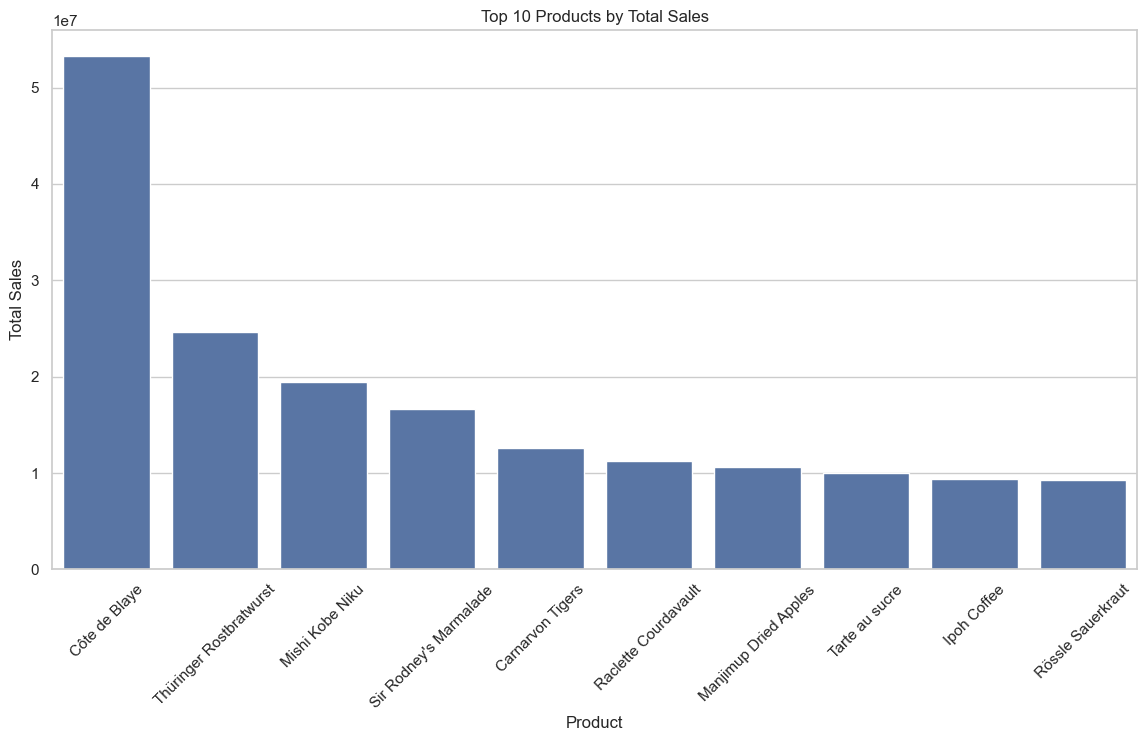

In [163]:
# Crear un gráfico de barras para mostrar los productos más vendidos
top_products = sales_data.head(10)  # Seleccionar los 10 productos más vendidos

plt.figure(figsize=(14, 7))
sns.barplot(x='Product', y='TotalSales', data=top_products, ci=None)
plt.title('Top 10 Products by Total Sales')
plt.xlabel('Product')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show() 

In [164]:
# Agrupar las ventas por categoría
category_sales = sales_data.groupby('Category').sum().reset_index() 

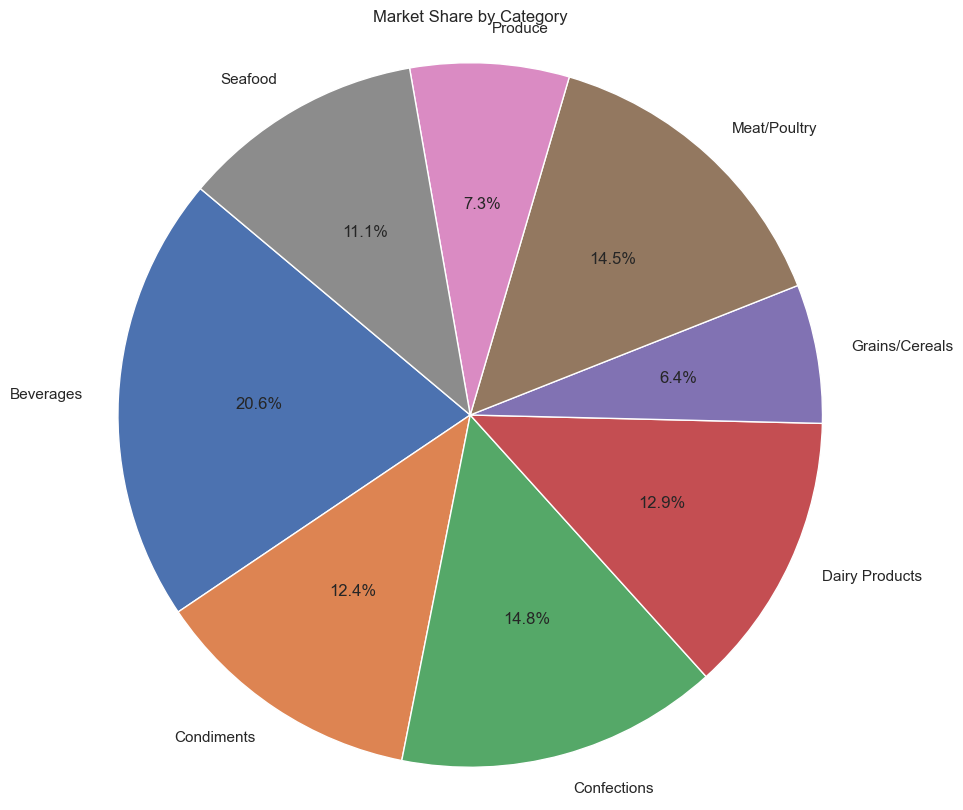

In [165]:
# Crear un gráfico de tarta para mostrar la participación de mercado de cada categoría
plt.figure(figsize=(10, 10))
plt.pie(category_sales['TotalSales'], labels=category_sales['Category'], autopct='%1.1f%%', startangle=140)
plt.title('Market Share by Category')
plt.axis('equal')  # Asegurar que el gráfico de tarta es circular
plt.show() 

### **3. Análisis de Rentabilidad de Clientes**
Analiza la rentabilidad de los clientes de la empresa. Examina los ingresos generados por cada cliente, así como los costos asociados con el servicio o producto proporcionado. 

Pista: Utiliza gráficos de dispersión y tablas dinámicas para identificar los clientes más rentables y aquellos que requieren mayor atención.

In [289]:
# Definir la consulta SQL
query = """
SELECT 
    c.CustomerID,
    c.CompanyName,
    SUM(od.Quantity * od.UnitPrice) AS TotalCost,
    SUM(od.Quantity * p.UnitPrice) AS TotalRevenue,
    (SUM(od.Quantity * p.UnitPrice) - SUM(od.Quantity * od.UnitPrice)) AS Profit
FROM 
    [Order Details] od
JOIN 
    Orders o ON od.OrderID = o.OrderID
JOIN 
    Customers c ON o.CustomerID = c.CustomerID
JOIN 
    Products p ON od.ProductID = p.ProductID
GROUP BY 
    c.CustomerID, c.CompanyName
ORDER BY 
    Profit DESC;
"""

In [290]:
# Conectar a la base de datos SQLite
db_path = 'C:/Users/rodri/OneDrive/Escritorio/DATA_SCIENCE/CODIGO_CLASES/TheBridge_DSPT-1/2-Data_Analysis/6-Bases_de_datos/Práctica/data/northwind.db'
connection = sqlite3.connect(db_path) 

In [291]:
# Ejecutar la consulta y cargar los datos en un DataFrame de Pandas
customer_profit_data = pd.read_sql_query(query, connection) 

In [296]:
# Crear una tabla dinámica
pivot_table = customer_profit_data.pivot_table(index='CompanyName', values=['TotalRevenue', 'TotalCost', 'Profit'], aggfunc='sum')

# Ordenar la tabla dinámica por 'Profit' en orden descendente
pivot_table_sorted = pivot_table.sort_values(by='Profit', ascending=False)

# Mostrar la tabla dinámica ordenada
print(pivot_table_sorted.head(25)) 

                               Profit   TotalCost  TotalRevenue
CompanyName                                                    
Ernst Handel                  7153.41  4550219.57    4557372.98
Rattlesnake Canyon Grocery    6316.52  4688963.11    4695279.63
Save-a-lot Markets            5045.46  4531376.69    4536422.15
QUICK-Stop                    4716.35  4946181.57    4950897.92
Mère Paillarde                4674.60  4880810.49    4885485.09
Queen Cozinha                 3817.80  5064050.46    5067868.26
Blondesddsl père et fils      3518.05  4706532.06    4710050.11
Piccolo und mehr              3335.05  5369557.36    5372892.41
Suprêmes délices              3214.00  4610546.73    4613760.73
Hungry Owl All-Night Grocers  3080.52  4739619.77    4742700.29
Frankenversand                3071.72  4437000.71    4440072.43
Simons bistro                 2923.80  4768815.29    4771739.09
Split Rail Beer & Ale         2228.82  4500398.94    4502627.76
HILARION-Abastos              2021.80  4

In [293]:
# Configurar estilos de Seaborn
sns.set_theme(style="whitegrid") 

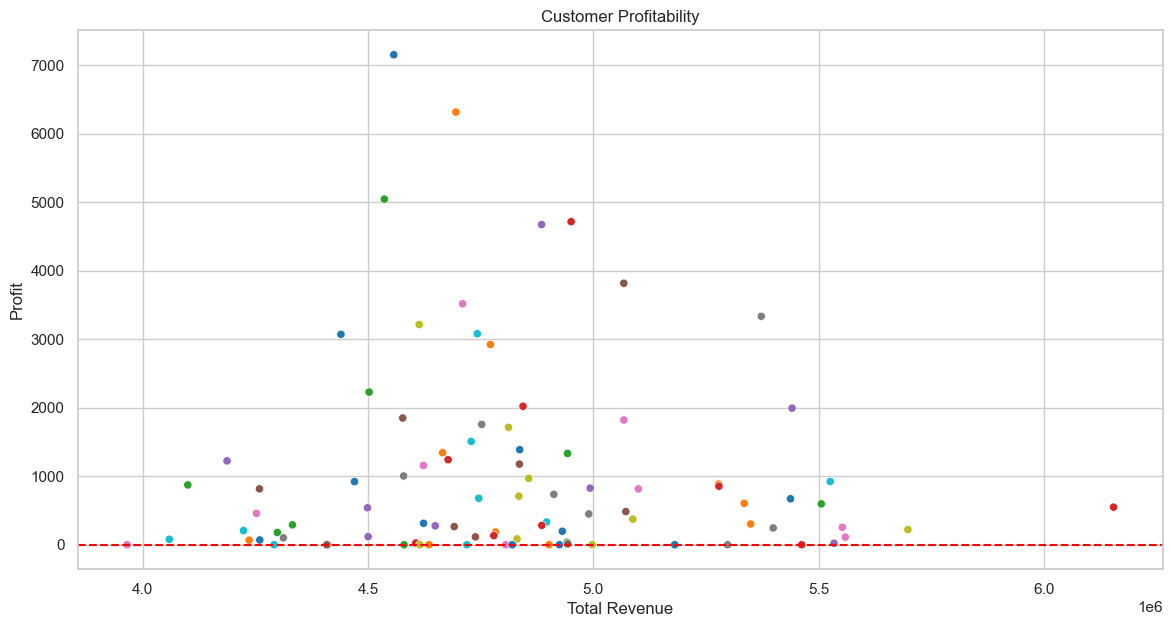

In [294]:
# Crear un gráfico de dispersión para visualizar la rentabilidad de los clientes
plt.figure(figsize=(14, 7))
sns.scatterplot(data=customer_profit_data, x='TotalRevenue', y='Profit', hue='CompanyName', palette='tab10', legend=None)
plt.title('Customer Profitability') 
plt.xlabel('Total Revenue')
plt.ylabel('Profit')
plt.axhline(0, color='red', linestyle='--')  # Línea horizontal en y=0 para indicar el punto de equilibrio
plt.show() 

### **4. Análisis de Inventarios y Proveedores**
Analiza los niveles de inventario y la gestión de proveedores de la empresa. Examina el inventario disponible por categoría de productos, así como el rendimiento de los proveedores en términos de puntualidad de entrega y calidad de los productos. 

Pista: Utiliza gráficos de líneas y tablas dinámicas para mostrar tendencias y comparar el desempeño de los proveedores.

In [309]:
# Consultas SQL para análisis
inventory_by_category_query = """
SELECT 
    c.CategoryName,
    SUM(p.UnitsInStock) AS TotalUnitsInStock,
    SUM(p.UnitsInStock * p.UnitPrice) AS TotalInventoryValue
FROM 
    Products p
JOIN 
    Categories c ON p.CategoryID = c.CategoryID
GROUP BY 
    c.CategoryName
ORDER BY 
    TotalInventoryValue DESC;
"""

# Ejecutar consultas y cargar los datos en DataFrames
inventory_by_category_df = pd.read_sql_query(inventory_by_category_query, connection).sort_values(by='TotalUnitsInStock', ascending= True)

In [311]:
# Visualizar datos de productos de inventario con una menor 'TotalUnitsInStock' de toda la base de datos  
print("Inventory by Category:\n", inventory_by_category_df.head(10)) 

Inventory by Category:
      CategoryName  TotalUnitsInStock  TotalInventoryValue
7         Produce                100              3549.35
5    Meat/Poultry                165              5729.45
6  Grains/Cereals                308              5594.50
4     Confections                386             10392.20
3  Dairy Products                393             11271.20
2      Condiments                507             12023.55
1       Beverages                559             12480.25
0         Seafood                701             13010.35


In [312]:
supplier_performance_query = '''
SELECT 
    s.CompanyName AS Supplier,
    COUNT(o.OrderID) AS TotalOrders,
    AVG(julianday(o.ShippedDate) - julianday(o.OrderDate)) AS AvgDeliveryTime,
    SUM(CASE WHEN o.ShippedDate <= o.RequiredDate THEN 1 ELSE 0 END) * 100.0 / COUNT(o.OrderID) AS OnTimeDeliveryRate,
    SUM(CASE WHEN od.Discount > 0 THEN 1 ELSE 0 END) * 100.0 / COUNT(od.OrderID) AS ReturnRate
FROM 
    Orders o
JOIN 
    'Order Details' od ON o.OrderID = od.OrderID
JOIN 
    Products p ON od.ProductID = p.ProductID
JOIN 
    Suppliers s ON p.SupplierID = s.SupplierID
GROUP BY 
    s.CompanyName
ORDER BY 
    OnTimeDeliveryRate DESC;
'''
# Ejecutar la consulta y cargar los datos en un DataFrame de Pandas
supplier_performance_df = pd.read_sql_query(supplier_performance_query, connection).sort_values(by='ReturnRate', ascending = False)

In [313]:
# Los proveedores que tienen un mayor 'ReturnRate' de toda la base de datos 
print("\nSupplier Performance:\n", supplier_performance_df.head(10)) 


Supplier Performance:
                                   Supplier  TotalOrders  AvgDeliveryTime  \
22                            Gai pâturage        15910         7.791410   
21               Refrescos Americanas LTDA         7881         7.825597   
9                                Ma Maison        15874         7.776993   
0              New England Seafood Cannery        15820         7.782870   
4                            Pavlova, Ltd.        39596         7.803124   
24                          Exotic Liquids        23741         7.850059   
17  Nord-Ost-Fisch Handelsgesellschaft mbH         7952         7.797594   
15                 Formaggi Fortini s.r.l.        23693         7.789974   
8                         Forêts d'érables        15868         7.837860   
16       Plutzer Lebensmittelgroßmärkte AG        39549         7.821282   

    OnTimeDeliveryRate  ReturnRate  
22           75.499686    0.270270  
21           75.510722    0.228397  
9            75.847297    0.

In [ ]:
# Ejecutar la consulta y cargar los datos en un DataFrame de Pandas
supplier_performance_df = pd.read_sql_query(supplier_performance_query, connection).sort_values(by='OnTimeDeliveryRate', ascending = False)

In [314]:
# Los proveedores que tienen una mayor 'OnTimeDeliveryRate' de toda la base de datos 
print("\nSupplier Performance:\n", supplier_performance_df.head(10)) 


Supplier Performance:
                                   Supplier  TotalOrders  AvgDeliveryTime  \
22                            Gai pâturage        15910         7.791410   
21               Refrescos Americanas LTDA         7881         7.825597   
9                                Ma Maison        15874         7.776993   
0              New England Seafood Cannery        15820         7.782870   
4                            Pavlova, Ltd.        39596         7.803124   
24                          Exotic Liquids        23741         7.850059   
17  Nord-Ost-Fisch Handelsgesellschaft mbH         7952         7.797594   
15                 Formaggi Fortini s.r.l.        23693         7.789974   
8                         Forêts d'érables        15868         7.837860   
16       Plutzer Lebensmittelgroßmärkte AG        39549         7.821282   

    OnTimeDeliveryRate  ReturnRate  
22           75.499686    0.270270  
21           75.510722    0.228397  
9            75.847297    0.

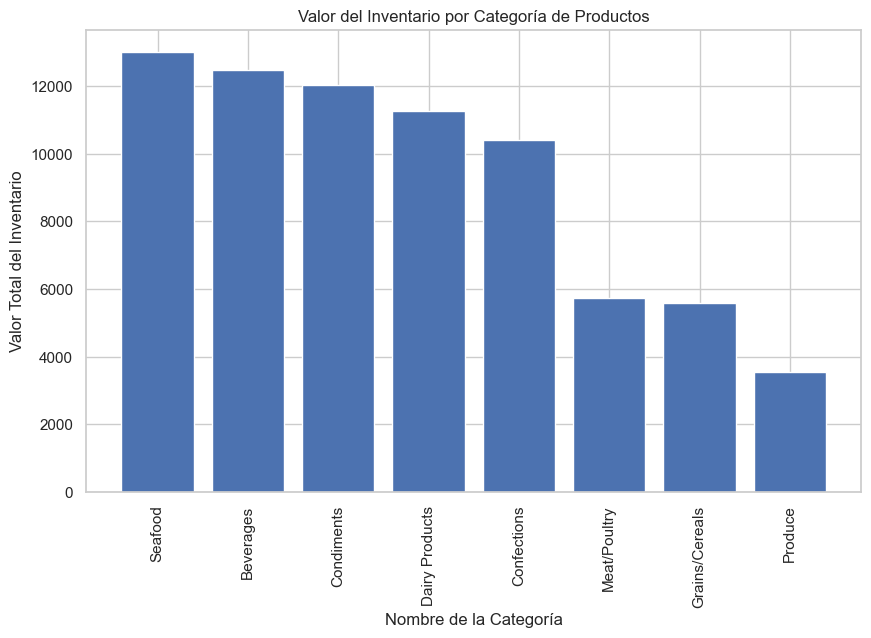

In [176]:
# Gráfico de barras del inventario por categoría de productos
plt.figure(figsize=(10, 6))
plt.bar(inventory_by_category_df['CategoryName'], inventory_by_category_df['TotalInventoryValue'])
plt.xlabel('Nombre de la Categoría')
plt.ylabel('Valor Total del Inventario')
plt.title('Valor del Inventario por Categoría de Productos')
plt.xticks(rotation=90)
plt.show()

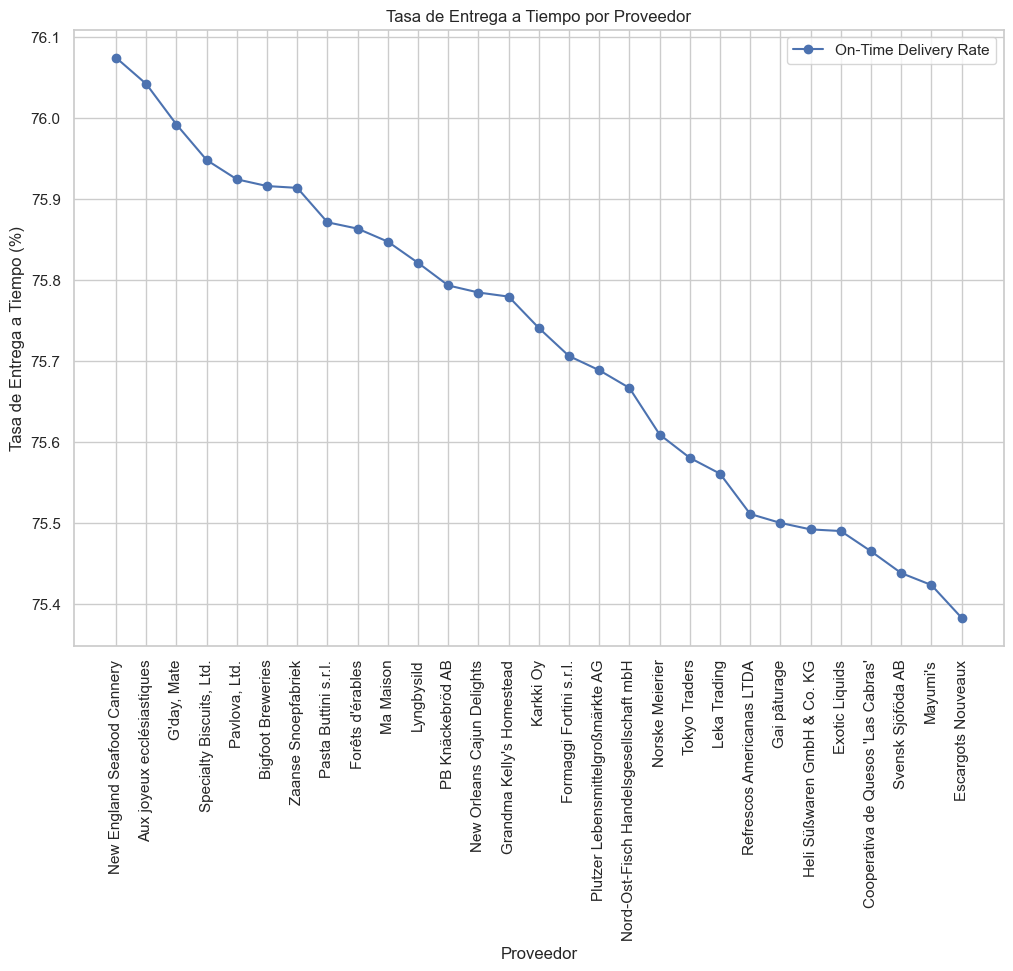

In [177]:
# Gráfico de líneas para la puntualidad de entrega de proveedores
plt.figure(figsize=(12, 8))
plt.plot(supplier_performance_df['Supplier'], supplier_performance_df['OnTimeDeliveryRate'], label='On-Time Delivery Rate', marker='o')
plt.xlabel('Proveedor')
plt.ylabel('Tasa de Entrega a Tiempo (%)')
plt.title('Tasa de Entrega a Tiempo por Proveedor')
plt.xticks(rotation=90)
plt.legend()
plt.show()

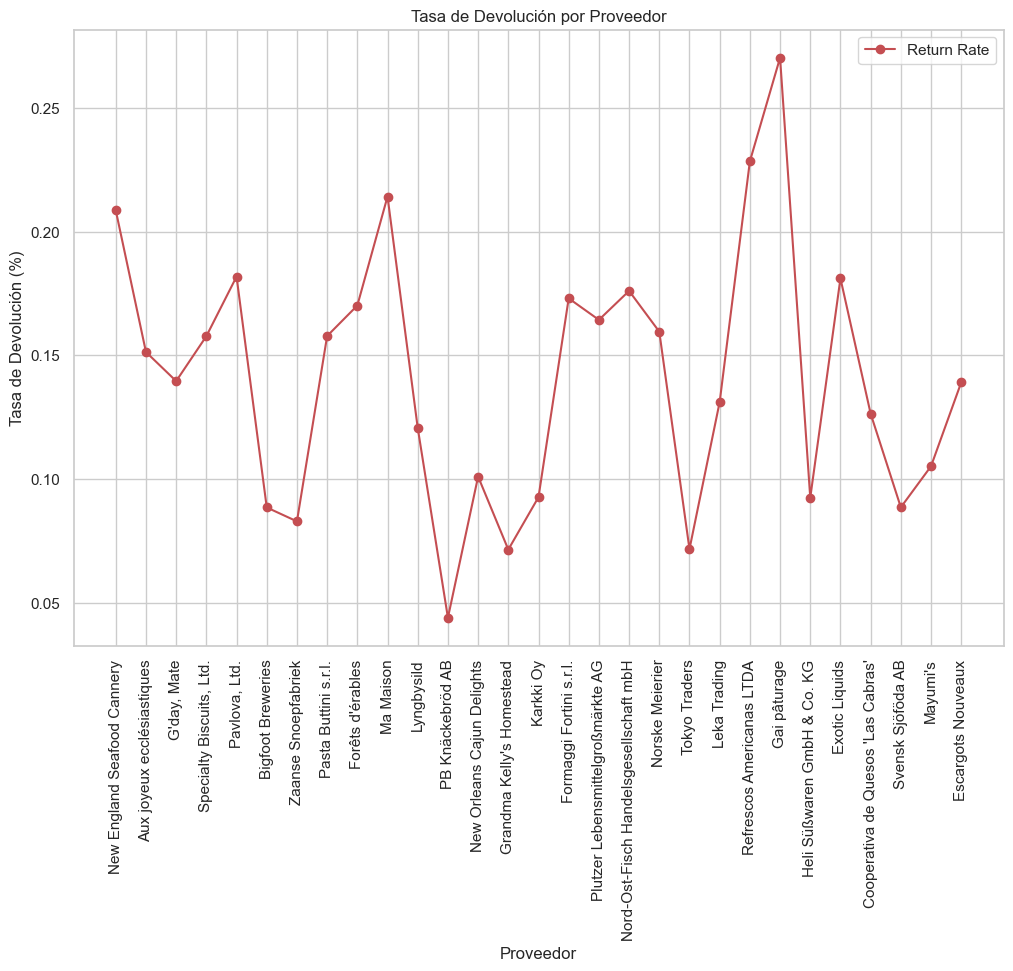

In [178]:
# Gráfico de líneas para la tasa de devolución de proveedores
plt.figure(figsize=(12, 8))
plt.plot(supplier_performance_df['Supplier'], supplier_performance_df['ReturnRate'], label='Return Rate', marker='o', color='r')
plt.xlabel('Proveedor')
plt.ylabel('Tasa de Devolución (%)')
plt.title('Tasa de Devolución por Proveedor')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [179]:
# Tabla dinámica para comparar el desempeño de los proveedores
pivot_table = pd.pivot_table(supplier_performance_df, values=['OnTimeDeliveryRate', 'ReturnRate'], index='Supplier')
print(pivot_table)

                                        OnTimeDeliveryRate  ReturnRate
Supplier                                                              
Aux joyeux ecclésiastiques                       76.042127    0.151353
Bigfoot Breweries                                75.916010    0.088544
Cooperativa de Quesos 'Las Cabras'               75.464661    0.126438
Escargots Nouveaux                               75.382476    0.139082
Exotic Liquids                                   75.489659    0.181121
Formaggi Fortini s.r.l.                          75.705905    0.173047
Forêts d'érables                                 75.863373    0.170154
G'day, Mate                                      75.992047    0.139606
Gai pâturage                                     75.499686    0.270270
Grandma Kelly's Homestead                        75.779376    0.071522
Heli Süßwaren GmbH & Co. KG                      75.491679    0.092453
Karkki Oy                                        75.740592    0.092706
Leka T

### **5. Análisis de Comportamiento de Empleados**
Analiza el comportamiento de los empleados de la empresa. Examina las ventas realizadas por cada empleado, así como su eficiencia en el manejo de pedidos y su puntualidad en la entrega de productos. 

Pista: Utiliza gráficos de barra y de dispersión para comparar el desempeño de los empleados y identificar áreas de mejora.

In [319]:
# Consulta SQL para análisis
sales_by_employee_query = """
SELECT 
    e.FirstName || ' ' || e.LastName AS EmployeeName,
    COUNT(o.OrderID) AS TotalOrders,
    SUM(od.Quantity * od.UnitPrice) AS TotalSales
FROM 
    Orders o
JOIN 
    Employees e ON o.EmployeeID = e.EmployeeID
JOIN 
    'Order Details' od ON o.OrderID = od.OrderID
GROUP BY 
    EmployeeName
ORDER BY 
    TotalSales DESC;
"""

# Ejecutar consultas y cargar los datos en DataFrames
sales_by_employee_df = pd.read_sql_query(sales_by_employee_query, connection).sort_values(by='TotalSales', ascending=True) 

# Cerrar la conexión a la base de datos
conn.close() 

In [320]:
# Visualizar datos de los empledos que venden menos de toda la base de datos 
print("Sales by Employee:\n", sales_by_employee_df.head(10)) 

Sales by Employee:
        EmployeeName  TotalOrders   TotalSales
8     Andrew Fuller        66365  48325312.27
7    Anne Dodsworth        66362  49025334.37
6    Michael Suyama        66190  49144251.53
5    Laura Callahan        67401  49287575.56
4       Robert King        67361  49668627.06
3     Nancy Davolio        67619  49669459.34
2   Janet Leverling        68246  50455812.22
1   Steven Buchanan        69868  51393234.57
0  Margaret Peacock        69871  51505691.80


In [315]:
# Consulta SQL para análisis 
employee_efficiency_query = """
SELECT 
    e.FirstName || ' ' || e.LastName AS EmployeeName,
    COUNT(o.OrderID) AS TotalOrders,
    AVG(julianday(o.ShippedDate) - julianday(o.OrderDate)) AS AvgHandlingTime,
    SUM(CASE WHEN o.ShippedDate <= o.RequiredDate THEN 1 ELSE 0 END) * 100.0 / COUNT(o.OrderID) AS OnTimeDeliveryRate
FROM 
    Orders o
JOIN 
    Employees e ON o.EmployeeID = e.EmployeeID
GROUP BY 
    EmployeeName
ORDER BY 
    EmployeeName;
"""

# Ejecutar consultas y cargar los datos en DataFrames
employee_efficiency_df = pd.read_sql_query(employee_efficiency_query, connection).sort_values(by='OnTimeDeliveryRate', ascending=False) 

# Cerrar la conexión a la base de datos
conn.close() 

In [316]:
# Visualizar los empleados que tienen un mayor 'OnTimeDeliveryRate' de toda la base de datos 
print("\nEmployee Efficiency:\n", employee_efficiency_df.head(10)) 


Employee Efficiency:
        EmployeeName  TotalOrders  AvgHandlingTime  OnTimeDeliveryRate
0     Andrew Fuller         1771         7.682021           78.317335
8   Steven Buchanan         1804         7.621073           77.882483
6     Nancy Davolio         1846         7.558939           77.843987
4  Margaret Peacock         1908         8.036024           77.725367
2   Janet Leverling         1846         7.833235           76.218852
5    Michael Suyama         1754         8.013659           76.168757
3    Laura Callahan         1798         7.874875           75.862069
1    Anne Dodsworth         1766         7.923082           75.651189
7       Robert King         1789         8.041034           75.517049


In [322]:
# Ejecutar consultas y cargar los datos en DataFrames
employee_efficiency_df = pd.read_sql_query(employee_efficiency_query, connection).sort_values(by='AvgHandlingTime', ascending=False) 

In [323]:
# Visualizar los datos de los empleados que se demoran más de media en sus tareas de toda la base de datos 
print("\nEmployee Efficiency:\n", employee_efficiency_df.head(10))  


Employee Efficiency:
        EmployeeName  TotalOrders  AvgHandlingTime  OnTimeDeliveryRate
7       Robert King         1789         8.041034           75.517049
4  Margaret Peacock         1908         8.036024           77.725367
5    Michael Suyama         1754         8.013659           76.168757
1    Anne Dodsworth         1766         7.923082           75.651189
3    Laura Callahan         1798         7.874875           75.862069
2   Janet Leverling         1846         7.833235           76.218852
0     Andrew Fuller         1771         7.682021           78.317335
8   Steven Buchanan         1804         7.621073           77.882483
6     Nancy Davolio         1846         7.558939           77.843987


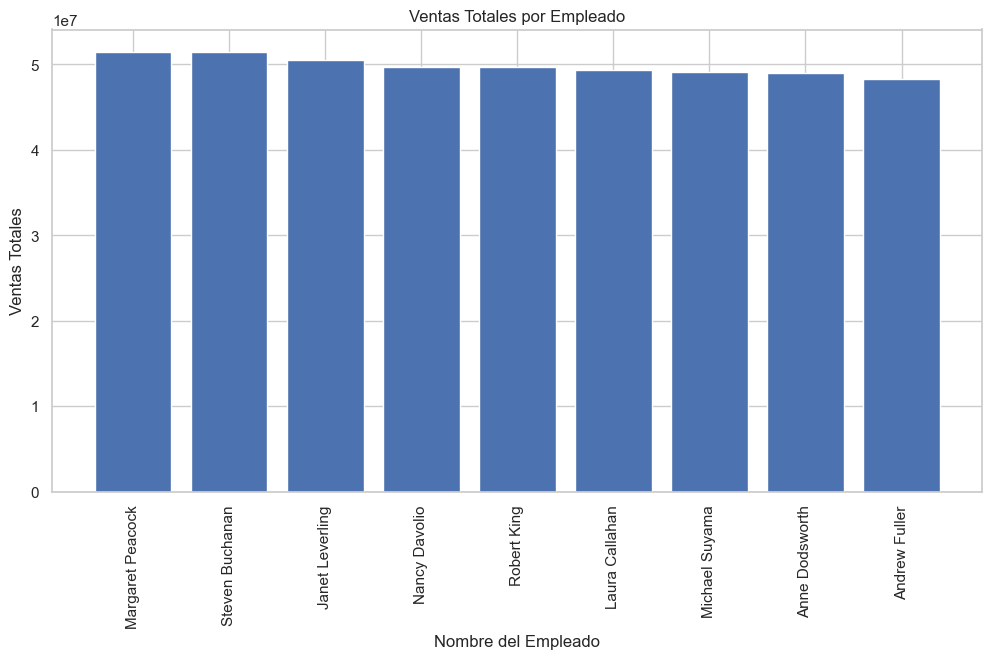

In [184]:
# Gráfico de barras de las ventas realizadas por cada empleado
plt.figure(figsize=(12, 6))
plt.bar(sales_by_employee_df['EmployeeName'], sales_by_employee_df['TotalSales'])
plt.xlabel('Nombre del Empleado')
plt.ylabel('Ventas Totales')
plt.title('Ventas Totales por Empleado')
plt.xticks(rotation=90)
plt.show() 

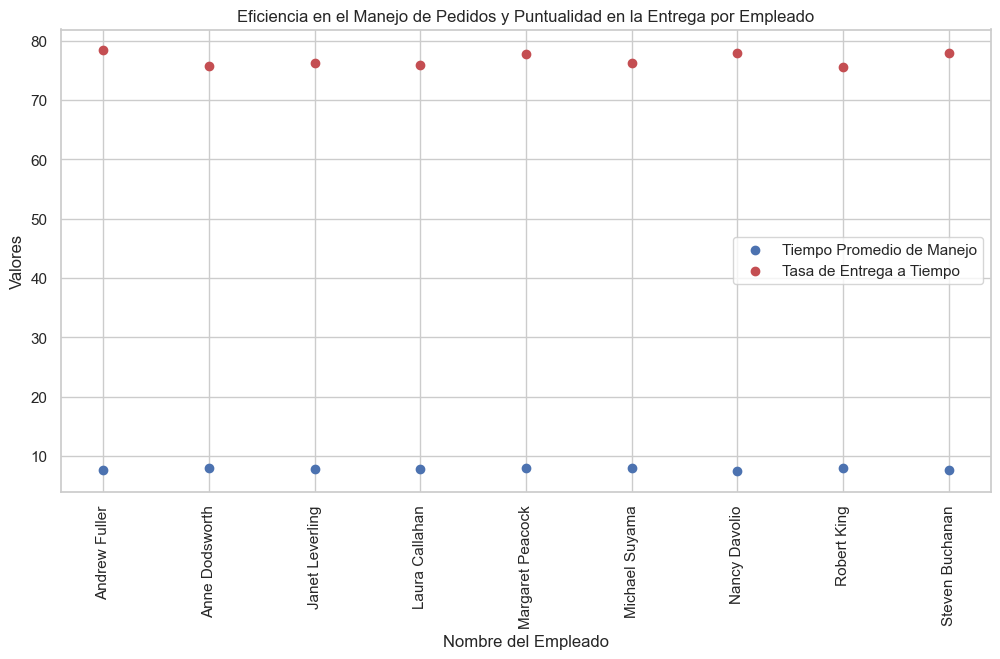

In [185]:
# Gráfico de dispersión de eficiencia en el manejo de pedidos y puntualidad en la entrega
plt.figure(figsize=(12, 6))
plt.scatter(employee_efficiency_df['EmployeeName'], employee_efficiency_df['AvgHandlingTime'], color='b', label='Tiempo Promedio de Manejo')
plt.scatter(employee_efficiency_df['EmployeeName'], employee_efficiency_df['OnTimeDeliveryRate'], color='r', label='Tasa de Entrega a Tiempo')
plt.xlabel('Nombre del Empleado')
plt.ylabel('Valores')
plt.title('Eficiencia en el Manejo de Pedidos y Puntualidad en la Entrega por Empleado')
plt.xticks(rotation=90)
plt.legend()
plt.show() 

In [186]:
# Tabla dinámica para comparar el desempeño de los empleados
pivot_table = pd.pivot_table(employee_efficiency_df, values=['AvgHandlingTime', 'OnTimeDeliveryRate'], index='EmployeeName')
print(pivot_table) 

                  AvgHandlingTime  OnTimeDeliveryRate
EmployeeName                                         
Andrew Fuller            7.682021           78.317335
Anne Dodsworth           7.923082           75.651189
Janet Leverling          7.833235           76.218852
Laura Callahan           7.874875           75.862069
Margaret Peacock         8.036024           77.725367
Michael Suyama           8.013659           76.168757
Nancy Davolio            7.558939           77.843987
Robert King              8.041034           75.517049
Steven Buchanan          7.621073           77.882483
